In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [2]:
single_done = set([1, 3, 12, 13, 19, 21])

already_done =   single_done.union( set([i for i in range(1,7)]) )

already_done = [i for i in range(1,23)]

In [3]:
stats = gpd.read_file('R:/kmoch/grid_tiles/DEM_1m_processing_zones.shp').to_crs(3301)

In [4]:
stats['id'] = pd.to_numeric(stats['id'], downcast='integer')

In [5]:
source_cols = [ 'specific_slopenlength_with_log',
                'specific_slopenlength_default',
                'buffer_size_with_log',
                'buffer_size_default',
               # 'specific_slopenlength_with_log_clipped',
               # 'specific_slopenlength_default_clipped',
                'buffer_size_with_log_clipped',
                'buffer_size_default_clipped',
              ]

In [ ]:
from rasterstats import zonal_stats
import os
import rasterio
import seaborn as sns

stats2 = []

for base_n in source_cols:
    for i in already_done:
        if 'buffer_size' in base_n:
            layer = f"{base_n}_pzone_{i}.tif"
            print(layer)
            
            dset = rasterio.open(layer, 'r')
            print(dset.meta)
            
            nodata = dset.nodata
            del dset
            t = zonal_stats(stats['geometry'], layer, stats=['max', 'mean', 'median'], all_touched=True, nodata=nodata)
            
            stats2.append({layer: t})

buffer_size_with_log_pzone_1.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 10000, 'height': 20000, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(5.0, 0.0, 365000.0,
       0.0, -5.0, 6485000.0)}
buffer_size_with_log_pzone_2.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 20000, 'height': 10000, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(5.0, 0.0, 615000.0,
       0.0, -5.0, 6635000.0)}
buffer_size_with_log_pzone_3.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 20000, 'height': 20000, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(5.0, 0.0, 665000.0,
       0.0, -5.0, 6435000.0)}
buffer_size_with_log_pzone_4.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 10000, 'height': 20000, 'count': 1, 'crs': CRS.from_epsg(3301), 'transform': Affine(5.0, 0.0, 515000.0,
       0.0, -5.0, 6485000.0)}
buffer_size_with_log_pzone_5.tif
{'driver': 'GTiff', 'dtype': 'float32',

In [ ]:
new_df2 = pd.DataFrame({'zone_id': [i for i in range(1,23)]})

for col in source_cols:
    for stat in ['max', 'mean', 'median']:
        sum_col = f"{col}_{stat}"
        new_df2[sum_col] = np.nan
        

In [ ]:
counter = 0

for base_n in source_cols:
    for i in already_done:
        if 'buffer_size' in base_n:
            layer = f"{base_n}_pzone_{i}.tif"
            print(layer)
            elem = stats2[counter]
            print(list(elem.keys())[0])
            
            for stat in ['max', 'mean', 'median']:
                sum_col = f"{base_n}_{stat}"
                
                x = stats2[counter][layer][i-1][stat]
                new_df2.loc[new_df2['zone_id'] == i, sum_col] = x
            
            counter = counter +1 

In [ ]:
stats_geo = gpd.GeoDataFrame( pd.merge(stats, new_df2, left_on='id', right_on='zone_id'), geometry='geometry', crs='EPSG:3301')

In [ ]:
stats_geo['cent'] = stats_geo.centroid
stats_geo['cent_x'] = stats_geo.apply(lambda g: g['cent'].x, axis=1)
stats_geo['cent_y'] = stats_geo.apply(lambda g: g['cent'].y, axis=1)

In [ ]:
eesti = gpd.read_file('R:/kmoch/grid_tiles/estonia_without_lakes.shp').to_crs(3301)

In [ ]:
stats_geo.describe()

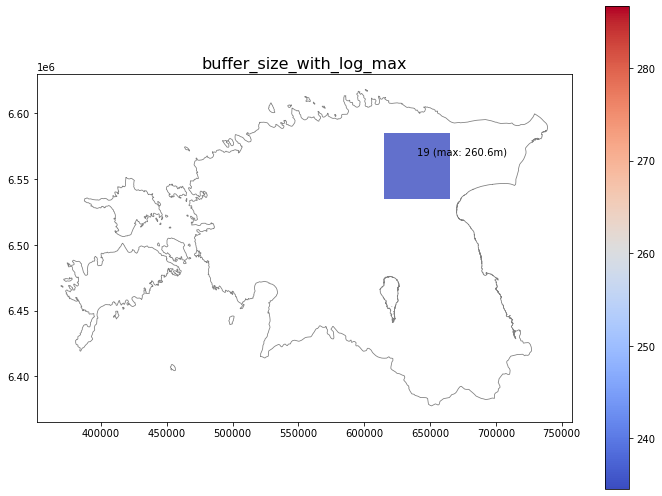

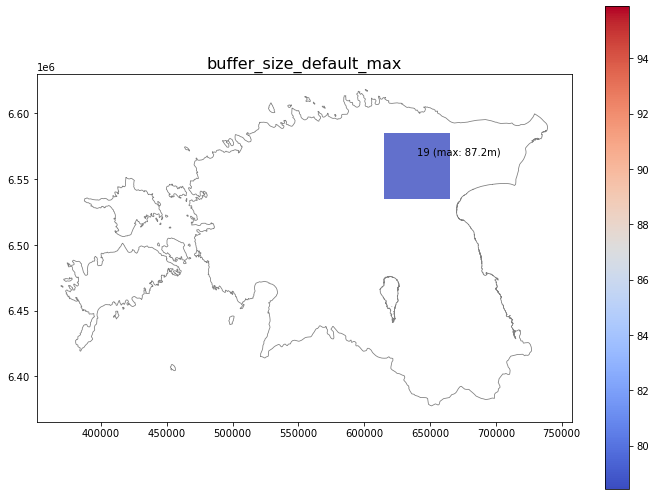

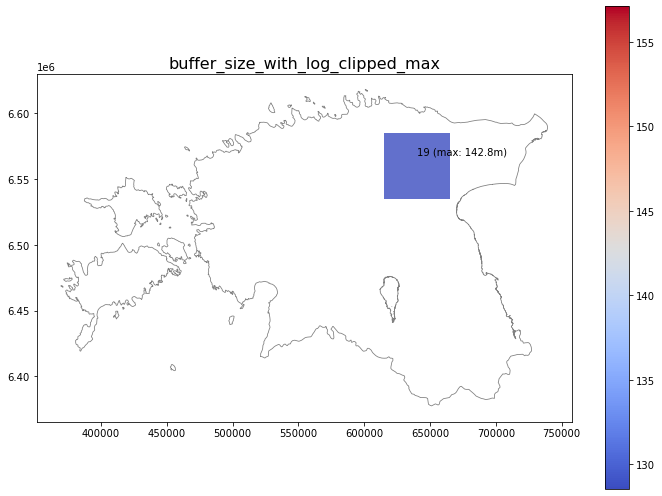

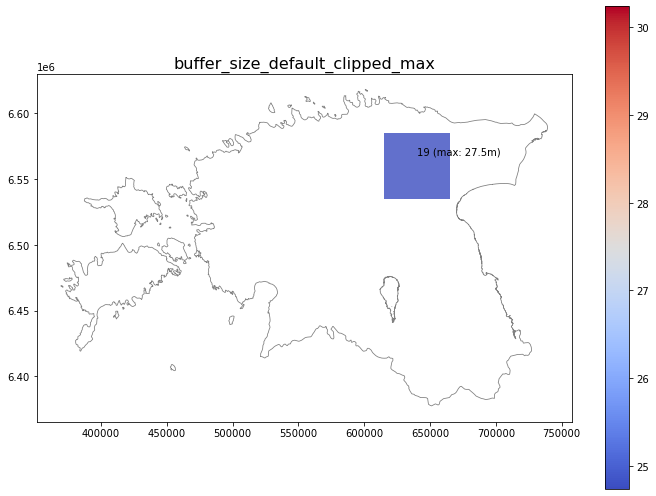

In [13]:
for x in filter(lambda x: 'max' in x, stats_geo.columns.tolist()):
    if 'buffer_size' in x:
        fig, ax = plt.subplots(figsize=(10,7))
        eesti.boundary.plot(edgecolor='grey', lw=0.8, ax=ax)
        stats_geo.loc[stats_geo[x] < 1000].plot(column=x, legend=True, ax=ax, alpha=0.8, cmap='coolwarm')
        
        for idx, row in stats_geo.iterrows():
            t_val = row[x]
            if not np.isnan(t_val):
                plt.text(row['cent_x'], row['cent_y'],"{} (max: {:.1f}m)\n".format(row['zone_id'],t_val),size=10, color='black')

        plt.title(f"{x}", fontsize=16)
        plt.tight_layout()

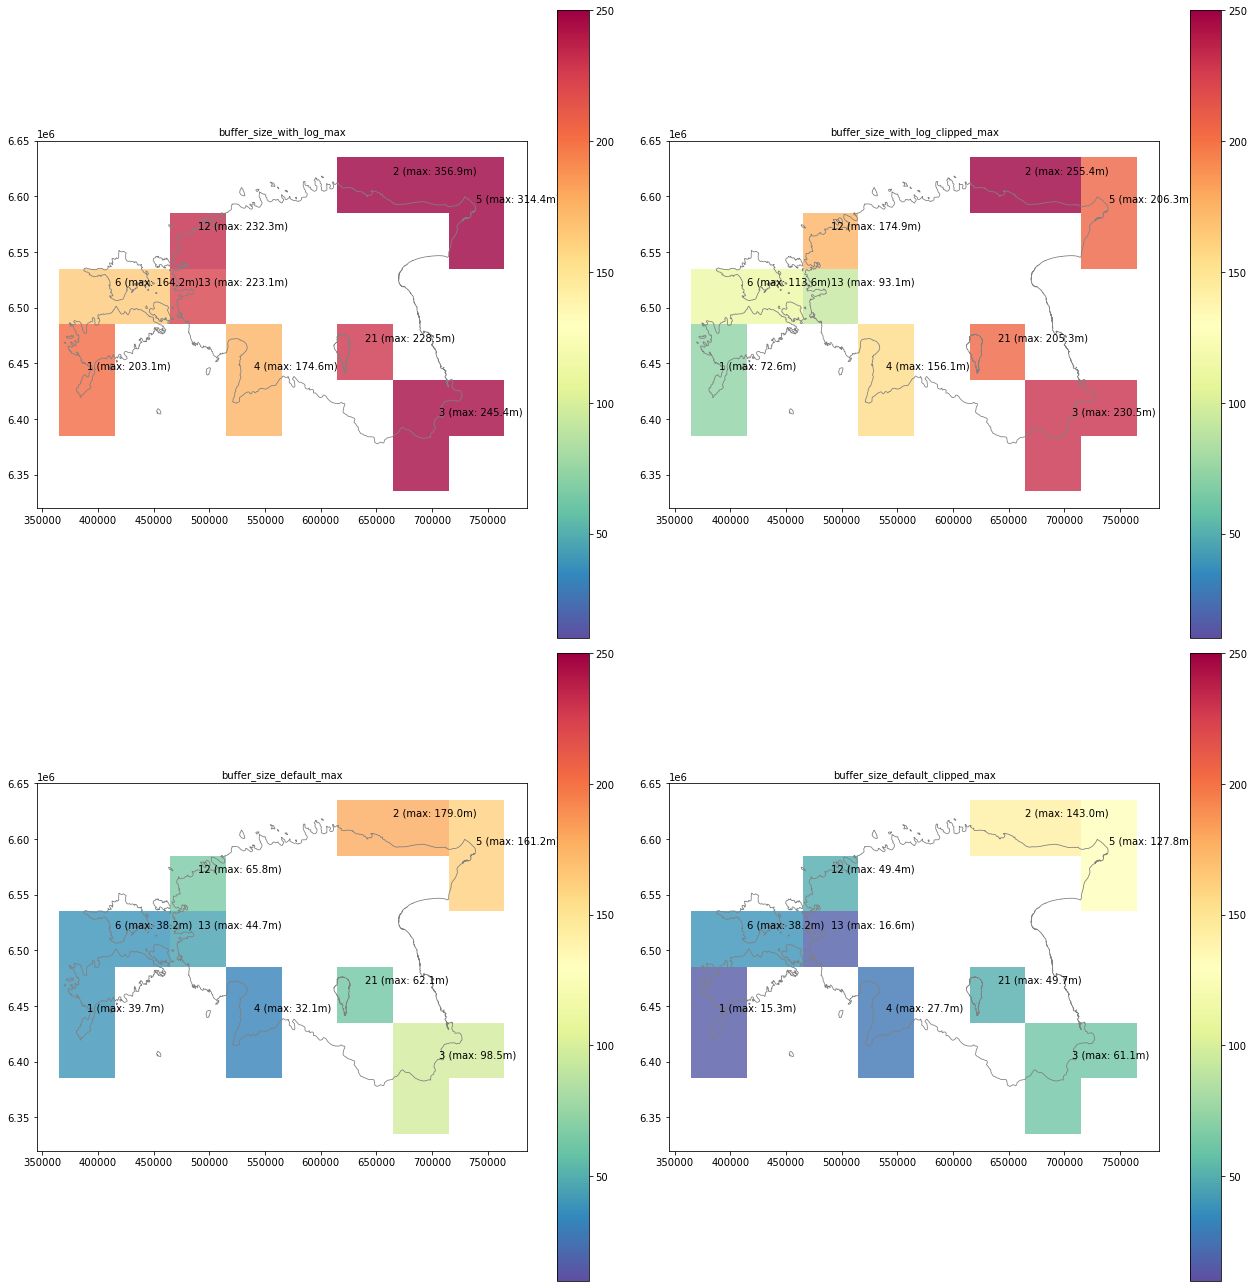

In [55]:
nrow = 0
ncol = 0

max_rows = 2
max_cols = 2

j = 0

fig, axs = plt.subplots(max_rows, max_cols, figsize=(18,18))

for x in  filter(lambda x: 'max' in x, stats_geo.columns.tolist()) :
    if 'buffer_size' in x:
        
        if j % max_rows == 0 and nrow > 0:
            ncol = ncol + 1

        nrow = j % max_rows
    
        # print(f"idx ({j}) row col ({ncol} / {nrow})")
        
        eesti.boundary.plot(edgecolor='grey', lw=0.8, ax=axs[nrow][ncol])
        stats_geo.plot(column=x, legend=True, ax=axs[nrow][ncol], alpha=0.8, cmap='Spectral_r', vmin=10, vmax=250)
        
        for idx, row in stats_geo.iterrows():
            t_val = row[x]
            if not np.isnan(t_val):
                axs[nrow][ncol].text(row['cent_x'], row['cent_y'],"{} (max: {:.1f}m)\n".format(row['zone_id'],t_val),size=10, color='black')

        ax=axs[nrow][ncol].set_title(f"{x}", fontsize=10)
        
        j=j+1

plt.savefig("stats_overview1.png", facecolor='white', transparent=False)
plt.tight_layout()

In [51]:
vee_voon_19 = gpd.read_file('../veekaitsekoond/veekaitsekonnd_dis_19.gpkg', driver="GPKG", layer="veekaitsekonnd_dis_19")

In [52]:
vee_voon_19

,Id,geometry
0,0,"MULTIPOLYGON (((627653.585 6535000.000, 627651..."
1,0,"MULTIPOLYGON (((620435.090 6535329.460, 620434..."
2,0,"MULTIPOLYGON (((619820.300 6535384.390, 619849..."
3,0,"MULTIPOLYGON (((626479.964 6535443.943, 626478..."
4,0,"MULTIPOLYGON (((645251.362 6535818.419, 645250..."
...,...,...
283,0,"MULTIPOLYGON (((657070.920 6584425.488, 657071..."
284,0,"MULTIPOLYGON (((632663.871 6585000.000, 632666..."
285,0,"MULTIPOLYGON (((657958.789 6585000.000, 657982..."
286,0,"MULTIPOLYGON (((653182.347 6585000.000, 653220..."


In [53]:
import shapely.geometry as sg
import shapely

vee19_new = []

for idx, row in vee_voon_19.iterrows():
    geom = row['geometry']
    